In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.stats import gaussian_kde
import random

In [2]:
# CONSTANTS
EPS = 1e-6
LAMBDA = 0.5
BINS = 20            # sürekli özelliklerde ortak bin sayısı
SMOOTH = 1e-9        # Laplace smoothing

LABEL_COL = "CONFIRMED DIAGNOSIS"
A1, A2, B = 1, 2, 3  # alt/üst yapı

In [3]:
# HELPERS: Entropy/JSD
def entropy(p, base=2):
    p = np.clip(p, 0, 1)
    p = p / p.sum()
    nz = p > 0
    logp = np.log(p[nz]) / np.log(base)
    return -np.sum(p[nz] * logp)

def jsd(p, q, base=2):
    p = p / p.sum()
    q = q / q.sum()
    m = 0.5 * (p + q)
    return 0.5 * (kl(p, m, base) + kl(q, m, base))

def kl(p, q, base=2):
    p = p / p.sum(); q = q / q.sum()
    nz = (p > 0) & (q > 0)
    return np.sum(p[nz] * (np.log(p[nz]) - np.log(q[nz])) / np.log(base))

In [4]:
# CONTINUOUS PROBABILITY VECTOR
def density_to_probs(x, bins):
    # x: 1D numpy (tek sınıf gözlemleri)
    hist, edges = np.histogram(x, bins=bins, density=False)
    p = hist.astype(float) + SMOOTH
    p /= p.sum()
    return p, edges

def density_to_probs_with_edges(x, edges):
    hist, _ = np.histogram(x, bins=edges, density=False)
    p = hist.astype(float) + SMOOTH
    p /= p.sum()
    return p

In [5]:
# CATEGORICAL PROBABILITY VECTOR
def categorical_probs(x):
    vc = pd.Series(x).value_counts(dropna=False)
    cats = vc.index.tolist()
    p = (vc.values.astype(float) + SMOOTH)
    p /= p.sum()
    return p, cats

def categorical_probs_on_cats(x, cats):
    vc = pd.Series(x).value_counts(dropna=False)
    arr = np.array([vc.get(c, 0.0) for c in cats], dtype=float) + SMOOTH
    arr /= arr.sum()
    return arr

In [6]:
# SUB-WEIGHT
def priors(y):
    vc = pd.Series(y).value_counts()
    total = vc.sum()
    pi = {k: vc[k] / total for k in vc.index}
    return pi

In [7]:
# JSD: BETWEEN-WITHIN CALCULATION
def jsd_between_within_for_feature(x, y, is_categorical=False):
    # x: feature, y: labels
    mask1 = (y == A1); mask2 = (y == A2); mask3 = (y == B)
    x1, x2, x3 = x[mask1], x[mask2], x[mask3]

    # secure less statusses
    if len(x1) < 2 or len(x2) < 2 or len(x3) < 2:
        return np.nan, np.nan, None  # D_top, D_in
    if is_categorical:
        p1, cats = categorical_probs(x1)
        p2 = categorical_probs_on_cats(x2, cats)
        p3 = categorical_probs_on_cats(x3, cats)
    else:
        # common edges
        _, edges = np.histogram(x, bins=BINS)
        p1 = density_to_probs_with_edges(x1, edges)
        p2 = density_to_probs_with_edges(x2, edges)
        p3 = density_to_probs_with_edges(x3, edges)

    pi = priors(y)
    alpha = pi.get(A1, 0) / max(pi.get(A1, 0) + pi.get(A2, 0), 1e-12)

    M_A = alpha * p1 + (1 - alpha) * p2

    D_top = jsd(M_A, p3)       # A (mixed) vs B
    D_in  = jsd(p1, p2)        # A inside

    return D_top, D_in, (p1, p2, p3, M_A, alpha)

In [8]:
# Z-SCORE, HF
def class_stats(x, y):
    stats = {}
    for c in [A1, A2, B]:
        xc = x[y == c]
        mu, sd = np.nanmean(xc), np.nanstd(xc, ddof=1) if len(xc) > 1 else (np.nan, np.nan)
        stats[c] = (mu, sd)
    return stats

def assign_nearest_class_and_z(xp, stats):
    best_c, best_absz, best_z = None, np.inf, None
    for c, (mu, sd) in stats.items():
        if sd is None or np.isnan(sd) or sd == 0 or np.isnan(mu):
            continue
        z = (xp - mu) / sd
        if abs(z) < best_absz:
            best_absz, best_z, best_c = abs(z), z, c
    return best_c, best_z

def H_of_class_probvec(p_vec):
    return entropy(p_vec, base=2)

In [9]:
# HIER-MATRIX
def compute_uncertainty_matrix(df, feature_cols, label_col=LABEL_COL, cat_cols=None,
                               lam=LAMBDA, eps=EPS):
    y = df[label_col].values
    X_mat = np.zeros((len(df), len(feature_cols)))
    meta = {}

    for j, f in enumerate(feature_cols):
        x = df[f].values
        is_cat = (cat_cols is not None and f in cat_cols)

        # Between-Within
        D_top, D_in, reps = jsd_between_within_for_feature(x, y, is_categorical=is_cat)
        if np.isnan(D_top) or np.isnan(D_in):
            X_mat[:, j] = np.nan
            continue

        S_f = max(eps, D_top - lam * D_in)

        # class statistics for z & H_f
        stats = class_stats(x, y)

        # probability vector selection for P_{f,c*} entropy
        p1, p2, p3, M_A, alpha = reps
        class_probvec = {A1: p1, A2: p2, B: p3}

        # per every patient
        for i, xp in enumerate(x):
            c_star, zpf = assign_nearest_class_and_z(xp, stats)
            if (c_star is None) or (zpf is None) or np.isnan(zpf):
                X_mat[i, j] = np.nan
                continue
            H_f = H_of_class_probvec(class_probvec[c_star])
            X_mat[i, j] = (H_f * zpf) / (S_f + eps)

        meta[f] = {"D_top": D_top, "D_in": D_in, "S_f": S_f, "alpha": alpha}

    return X_mat, meta

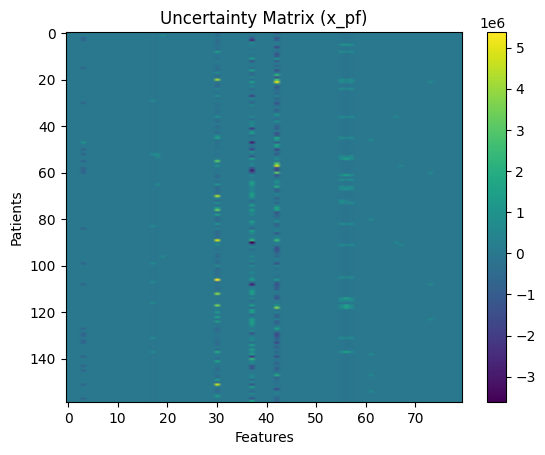

                                              feature     D_top          D_in  \
0                                                GRUP  1.000000  9.195238e-12   
79                                             STATIN  0.851298  4.120259e-02   
70  CAG_Critical 1 Non-Critical Stenosis 2  normal...  0.833601  3.681136e-02   
69                                      CAG_stenosis   0.778173  2.909334e-02   
71                           DARLIK_OLAN_DAMAR_SAYISI  0.774455  3.681136e-02   
2                                                 AGE  0.755789  2.228188e-01   
62                                            MRI_T2   0.696835  3.144108e-01   
78                                                ACE  0.491726  7.666686e-03   
76                                                ASA  0.457133  4.769661e-05   
63                                            MRI_LGE  0.696835  4.881141e-01   
1                                            PROTOKOL  0.550788  2.058821e-01   
28                          

In [11]:
df = pd.read_excel("hier-data.xlsx")
df = df.dropna(axis=1, how="all")
df = df.loc[:, df.nunique() > 1]
thresh = int(len(df) * 0.1)
df = df.dropna(axis=1, thresh=thresh)

num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != LABEL_COL]

df[num_cols] = df[num_cols].apply(lambda c: c.fillna(c.mean()))

# feature list
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in [LABEL_COL]]  # except label

cat_cols = []

# X & meta
X, meta = compute_uncertainty_matrix(df, feature_cols=num_cols, label_col=LABEL_COL, cat_cols=cat_cols)

# visualization
plt.imshow(np.nan_to_num(X), aspect="auto")
plt.colorbar(); plt.title("Uncertainty Matrix (x_pf)"); plt.xlabel("Features"); plt.ylabel("Patients")
plt.show()

report = pd.DataFrame([{ "feature": f, **meta[f]} for f in meta])
report = report.sort_values("S_f", ascending=False)
print(report.head(15))


VISUALIZATION

In [12]:
# STANDARDIZATION
X_std = (X - np.nanmean(X, axis=0)) / (np.nanstd(X, axis=0) + 1e-9)
X_std = np.nan_to_num(X_std)

# t-SNE EMBEDDING
# (perplexity = 50)
tsne = TSNE(n_components=2, perplexity=50, random_state=42)
X_emb = tsne.fit_transform(X_std)

df_emb = pd.DataFrame({
    "x": X_emb[:, 0],
    "y": X_emb[:, 1],
    "label": df[LABEL_COL].values
})

/tmp/ipython-input-3427541805.py:2: RuntimeWarning: Mean of empty slice
  X_std = (X - np.nanmean(X, axis=0)) / (np.nanstd(X, axis=0) + 1e-9)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [13]:
# KDE
grid_size = 400
xgrid = np.linspace(df_emb.x.min(), df_emb.x.max(), grid_size)
ygrid = np.linspace(df_emb.y.min(), df_emb.y.max(), grid_size)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
positions = np.vstack([Xgrid.ravel(), Ygrid.ravel()])

densities = {}
quantiles = {}
for c in [1, 2, 3]:
    pts = df_emb[df_emb.label == c][["x", "y"]].values.T
    kde = gaussian_kde(pts, bw_method="scott")
    z = np.reshape(kde(positions).T, Xgrid.shape)
    densities[c] = z
    q = np.quantile(z, 0.60)  # 60th-percentile density core
    quantiles[c] = q

# RGBA LAYER PREP
def alpha_norm(z):
    # normalize density for alpha
    z = np.sqrt(z / np.percentile(z, 98))
    return np.clip(z, 0, 1)

A1 = alpha_norm(densities[1])
A2 = alpha_norm(densities[2])
A3 = alpha_norm(densities[3])

# binary masks for high-density core areas
R = (densities[1] >= quantiles[1]).astype(float)
O = (densities[2] >= quantiles[2]).astype(float)
B = (densities[3] >= quantiles[3]).astype(float)

# blend 1 and 2
Rmix = np.clip(R + 0.6 * O, 0, 1)
Amix = np.clip(A1 + A2, 0, 1) / 2

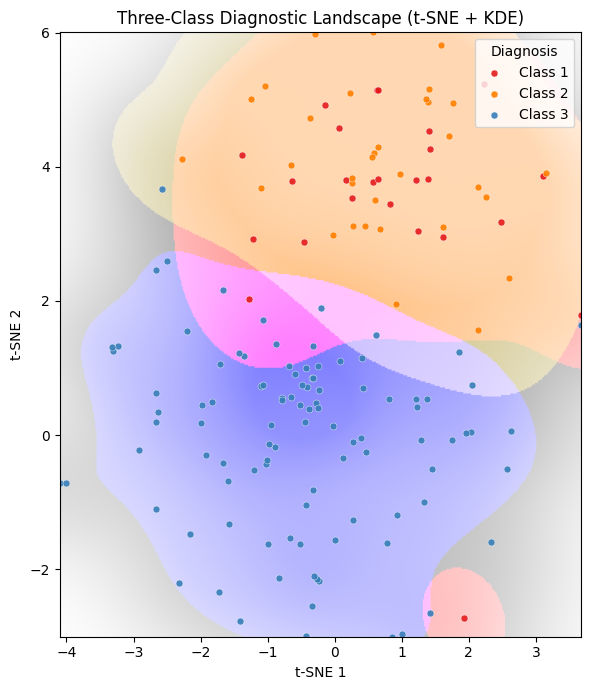

In [14]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.imshow(
    np.dstack((Rmix, 0.5 * O, B, 0.6 * Amix + 0.4 * A3)),
    extent=[xgrid.min(), xgrid.max(), ygrid.min(), ygrid.max()],
    origin="lower"
)

colors = {1: "#e41a1c", 2: "#ff7f00", 3: "#377eb8"}
for c in [1, 2, 3]:
    subset = df_emb[df_emb.label == c]
    ax.scatter(
        subset.x, subset.y,
        s=25, color=colors[c],
        alpha=0.9, edgecolor="white", linewidth=0.3,
        label=f"Class {c}"
    )

ax.legend(title="Diagnosis", loc="upper right", frameon=True)
ax.set_title("Three-Class Diagnostic Landscape (t-SNE + KDE)")
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
plt.tight_layout()
plt.show()

CASE STUDY - devam edilecek